<a href="https://colab.research.google.com/github/tettey-exploits/Team-FarmNETS/blob/main/crop_disease_notebook/FarmNETS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# FarmNETS - Crop Disease Detection for the Sub-Saharan Region

Crop Disease Ghana Dataset: An afrocentric dataset to ensure FarmNETS is effective in the sub-saharan region. Training a model to perform crop disease classification using images from the Sub-Saharan region is crucial for several reasons:

1. **Regional Specificity:** Crop diseases prevalent in the Sub-Saharan region may differ from those found in other parts of the world due to factors such as climate, soil conditions, and agricultural practices. Training a model using locally sourced images ensures that it is tailored to recognize and classify diseases relevant to farmers in the region accurately.

2. **Local Context:** Local farmers in the Sub-Saharan region may face unique challenges and constraints related to agricultural production, including limited access to resources, extension services, and technical expertise. A model trained on images from the region can take into account these contextual factors and provide recommendations that are practical and feasible within the local context.

3. **Empowering Local Communities:** Developing expertise and capabilities in crop disease classification within the Sub-Saharan region empowers local researchers, agricultural experts, and farmers to take ownership of addressing agricultural challenges. It promotes knowledge sharing, capacity building, and innovation within the region, fostering sustainable and self-reliant agricultural systems.

4. **Resilience to Climate Change:** The Sub-Saharan region is particularly vulnerable to the impacts of climate change, which can exacerbate the spread of crop diseases and pests. A robust crop disease classification model trained on region-specific data can help farmers anticipate and respond to changing disease patterns, enhancing resilience to climate-related challenges.

In summary, training a model to perform crop disease classification using images from the Sub-Saharan region is essential for ensuring accurate, contextually relevant, and effective disease management strategies that support the livelihoods and food security of local farmers.







### Import Libraries

In [ ]:
# Import required libraries
import zipfile
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import numpy as np
import random
from google.colab import drive
import shutil
from google.colab import files
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from google.colab import files
import time
from sklearn.utils import compute_class_weight
import glob
tf.__version__ # expected: 2.15.0

'2.15.0'

In [ ]:
# unwanted_folders = []
drive.mount('/content/drive')
# saved_models_dir = "/content/drive/MyDrive/AgricDis_Project/models/saved_trained_models/"
dataset_zip_path ='/content/crop-disease-ghana.zip'
old_dataset_path = "/content/input"
# drive_dataset_path = "/content/drive/MyDrive/AgricDis_Project/rail_crop_disease_dataset/crop_disease_ghana_dataset_agridis/"
# saved_tfdataset_path = "/content/drive/MyDrive/AgricDis_Project/rail_crop_disease_dataset/saved_tfdataset_crop_disease_ghana_agridis/"

Mounted at /content/drive


In [ ]:
def check_directories(path_l, del_unwanted_dir=True):

  def should_delete_directory(dirpath): # Function to check if a directory should be deleted
      for unwanted_dir in unwanted_folders:
          if unwanted_dir in dirpath:
              return True
      return False
  # Inspect the data
  for dirpath, dirnames, filenames in os.walk(path_l):
    if should_delete_directory(dirpath) and del_unwanted_dir: # Check if the current directory should be deleted
        shutil.rmtree(dirpath)
        print(f"{dirpath} has been deleted")
        continue  # Skip the rest of the loop for this directory
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

## Dataset Preparation
Crop disease dataset from RAIL. Dataset consists of images of 18 diseases across 3 crops. Images were taken in Ghana


1.   Tomato
2.   Pepper
3.   Maize

Dataset is publicly available on kaggle as [Crop Disease Ghana](https://www.kaggle.com/datasets/responsibleailab/crop-disease-ghana)



In [ ]:
# Download dataset from google drive
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/AgricDis_Project/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d responsibleailab/crop-disease-ghana

100% 18.7G/18.7G [10:29<00:00, 30.3MB/s]
100% 18.7G/18.7G [10:29<00:00, 31.8MB/s]


In [ ]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile(dataset_zip_path)
zip_ref.extractall()
zip_ref.close()

In [ ]:
!rm crop-disease-ghana.zip  # delete downloaded crop disease zip file to save storage space

In [ ]:
unwanted_folders = ['annotations']
old_dataset_path = "/content/input/"
dataset_path = "/content/crop_disease_ghana_dataset_agridis/"
class_names = []

In [ ]:
check_directories(old_dataset_path, del_unwanted_dir=False)

There are 3 directories and 5 images in /content/input/
There are 7 directories and 0 images in /content/input/Pepper
There are 2 directories and 0 images in /content/input/Pepper/Pepper__Cercospora_Leaf_Spot
There are 0 directories and 493 images in /content/input/Pepper/Pepper__Cercospora_Leaf_Spot/annotations
There are 0 directories and 493 images in /content/input/Pepper/Pepper__Cercospora_Leaf_Spot/images
There are 2 directories and 0 images in /content/input/Pepper/Pepper__Healthy
There are 0 directories and 405 images in /content/input/Pepper/Pepper__Healthy/annotations
There are 0 directories and 405 images in /content/input/Pepper/Pepper__Healthy/images
There are 2 directories and 0 images in /content/input/Pepper/Pepper__Leaf_Blight
There are 0 directories and 95 images in /content/input/Pepper/Pepper__Leaf_Blight/annotations
There are 0 directories and 95 images in /content/input/Pepper/Pepper__Leaf_Blight/images
There are 2 directories and 0 images in /content/input/Pepper/


#### Split data into training and test sets

In [ ]:
# automatically generate dataset sizes for individual dieasese
def generate_dataset_sizes(path=None, dataset="all"):
  '''
    Generates a dictionary of classes and their corresponding sizes in a given dataset directory

    Args:
      path: The path to generate the data sizes from. When None,
      dataset: Can be - all, train, test, valid
        all: generate sizes for the enitire dataset
        train: generate sizes for the train dataset
        test: generate sizes for the test dataset
        valid: generate sizes for the test dataset

    Returns:
      A dictionary of classes and their corresponding sizes in the specified dataset
  '''

  total_dataset_size = 0
  generated_class_sizes = {}

  def generate_split_size(split):
    dataset_size = 0
    use_path = f"{drive_dataset_path}/{split}"
    for dirpath, dirnames, filenames in os.walk(use_path):
          # Check if the current directory should be deleted
      if len(dirnames) == 0:
        list_n = dirpath.split("/")
        if list_n[-1] in generated_class_sizes:
          generated_class_sizes[list_n[-1]] += len(filenames)
        else:
          generated_class_sizes[list_n[-1]] = len(filenames)
      dataset_size += len(filenames)
    return dataset_size


  if dataset == "all":
    for path in ["valid", "test", "train"]:
      total_dataset_size += generate_split_size(path)
  else:
    total_dataset_size += generate_split_size(dataset)


  print(f"Individual class sizes: {generated_class_sizes}")
  print(f"Total dataset size: {total_dataset_size}")

  return generated_class_sizes

In [ ]:
train_size_ratio = 0.6
test_size_ratio = 0.2
valid_size_ratio = 0.2

In [ ]:
os.makedirs(f"{dataset_path}train", exist_ok=True)
os.makedirs(f"{dataset_path}valid", exist_ok=True)
os.makedirs(f"{dataset_path}test", exist_ok=True)

In [ ]:
# Split dataset into train, validation and test datasets
def split_dataset():
  class_names = []
  for class_name, class_size in class_sizes.items():
    class_n = class_name.split("/")[-1]
    class_names.append(class_n)
    data_dir = pathlib.Path(f"{old_dataset_path}/{class_name}/images/")
    train_data = f"{dataset_path}/train/{class_n}"
    valid_data = f"{dataset_path}/valid/{class_n}"
    test_data = f"{dataset_path}/test/{class_n}"

    pathlib.Path(train_data).mkdir(parents=True, exist_ok=True)
    pathlib.Path(valid_data).mkdir(parents=True, exist_ok=True)
    pathlib.Path(test_data).mkdir(parents=True, exist_ok=True)

    file_count = 1
    for item in data_dir.glob("*"):
      filename = item.name
      if file_count < train_size_ratio * class_size:
        shutil.move(f"{old_dataset_path}/{class_name}/images/{filename}", train_data)
      elif file_count < (train_size_ratio + valid_size_ratio) * class_size:
        shutil.move(f"{old_dataset_path}/{class_name}/images/{filename}", valid_data)
      else:
        shutil.move(f"{old_dataset_path}/{class_name}/images/{filename}", test_data)

      file_count +=1
split_dataset()
print(class_names)

NameError: name 'class_sizes' is not defined

In [ ]:
# Confirm dataset has been split properly
def comfirm_split():
  split_dir = {"/test": test_size_ratio, "/train": train_size_ratio, "/valid": valid_size_ratio}
  for s_dir, s_ratio in split_dir.items():
    current_split_size = 0
    for dirpath, dirnames, filenames in os.walk(dataset_path + s_dir):
      if len(dirnames) == 0:
        current_split_size += len(filenames)
    if round(current_split_size / total_dataset_size, 1) == s_ratio:
      print(f"{s_dir}: {current_split_size}. Split accurate")
    else:
      print(f"{s_dir}: {current_split_size}. Split inaccurate")
  print("Check complete")
confirm_split()

In [ ]:
# Setup paths to our data directories
train_dir = f"{drive_dataset_path}/new_train"
valid_dir = f"{drive_dataset_path}/valid"
test_dir = f"{drive_dataset_path}/test"

In [ ]:
# Hard coded class names and their corresponding data sizes
train_classes_size = generate_dataset_sizes(dataset="train") #{'Corn/Corn__Northern_Leaf_Blight': 90, 'Corn/Corn__Cercospora_Leaf_Spot': 949, 'Corn/Corn__Common_Rust': 355, 'Corn/Corn__Healthy': 352, 'Corn/Corn__Streak': 532, 'Tomato/Tomato__Fosarium': 126, 'Tomato/Tomato__Septoria': 217, 'Tomato/Tomato__Early_Blight': 325, 'Tomato/Tomato__Leaf_curl': 34, 'Tomato/Tomato__Healthy': 338, 'Tomato/Tomato__Late_Blight': 1347, 'Tomato/Tomato__Mosaic': 23, 'Pepper/Pepper__Leaf_Blight': 95, 'Pepper/Pepper__Cercospora_Leaf_Spot': 493, 'Pepper/Pepper__Leaf_Curl': 1047, 'Pepper/Pepper__Septoria': 217, 'Pepper/Pepper__Mosaic': 833, 'Pepper/Pepper__Fusarium': 398, 'Pepper/Pepper__Healthy': 405}
valid_classes_size = generate_dataset_sizes(dataset="valid")
test_classes_size = generate_dataset_sizes(dataset="test")
all_classes_size = generate_dataset_sizes(dataset="all")
class_names = list(all_classes_size.keys()) # ['Corn__Northern_Leaf_Blight', 'Corn__Cercospora_Leaf_Spot', 'Corn__Common_Rust', 'Corn__Healthy', 'Corn__Streak', 'Tomato__Fosarium', 'Tomato__Septoria', 'Tomato__Early_Blight', 'Tomato__Leaf_curl', 'Tomato__Healthy', 'Tomato__Late_Blight', 'Tomato__Mosaic', 'Pepper__Leaf_Blight', 'Pepper__Cercospora_Leaf_Spot', 'Pepper__Leaf_Curl', 'Pepper__Septoria', 'Pepper__Mosaic', 'Pepper__Fusarium', 'Pepper__Healthy']

Individual class sizes: {'Corn__Northern_Leaf_Blight': 270, 'Corn__Cercospora_Leaf_Spot': 569, 'Corn__Common_Rust': 1060, 'Corn__Healthy': 1055, 'Corn__Streak': 1595, 'Tomato__Fosarium': 375, 'Tomato__Septoria': 650, 'Tomato__Early_Blight': 970, 'Tomato__Leaf_curl': 100, 'Tomato__Healthy': 1010, 'Tomato__Late_Blight': 808, 'Tomato__Mosaic': 65, 'Pepper__Leaf_Blight': 280, 'Pepper__Cercospora_Leaf_Spot': 1475, 'Pepper__Leaf_Curl': 628, 'Pepper__Septoria': 650, 'Pepper__Mosaic': 499, 'Pepper__Fusarium': 1190, 'Pepper__Healthy': 1210}
Total dataset size: 14459
Individual class sizes: {'Corn__Northern_Leaf_Blight': 18, 'Corn__Cercospora_Leaf_Spot': 190, 'Corn__Common_Rust': 71, 'Corn__Healthy': 70, 'Corn__Streak': 106, 'Tomato__Fosarium': 25, 'Tomato__Septoria': 43, 'Tomato__Early_Blight': 65, 'Tomato__Leaf_curl': 7, 'Tomato__Healthy': 68, 'Tomato__Late_Blight': 269, 'Tomato__Mosaic': 5, 'Pepper__Leaf_Blight': 19, 'Pepper__Cercospora_Leaf_Spot': 99, 'Pepper__Leaf_Curl': 209, 'Pepper__Septo



 > Plot Class Distributions



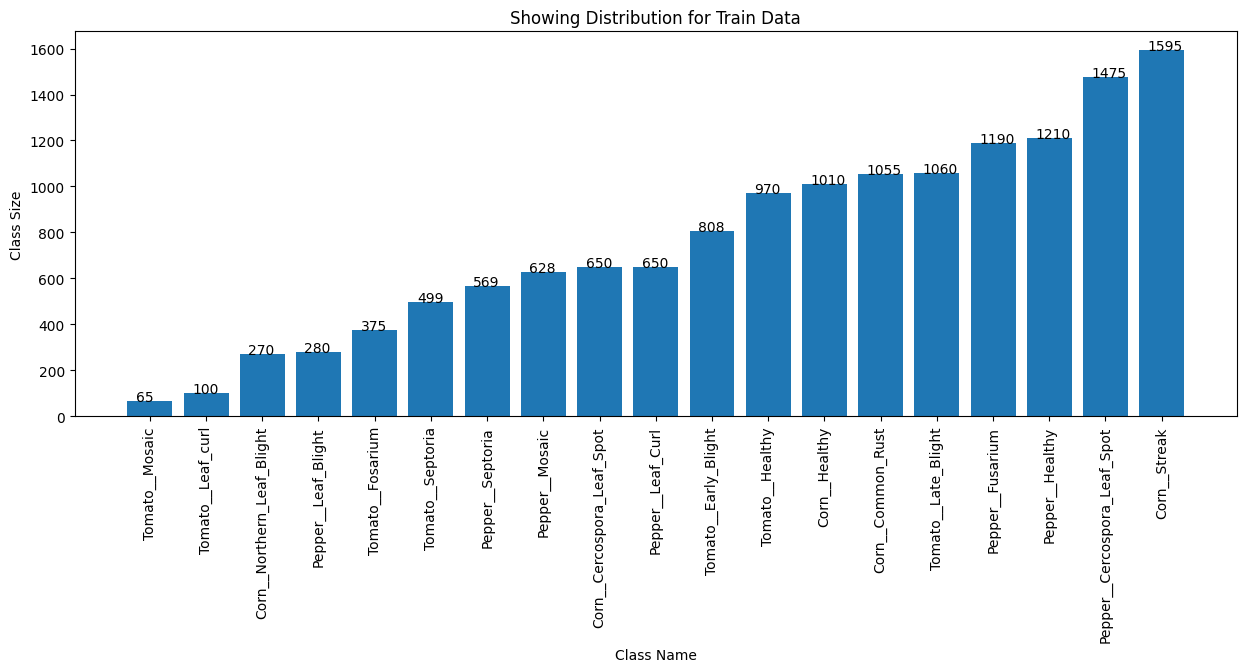

In [ ]:
def plot_class_distribution(distribution="all", sort=False):

  if distribution == "test" or distribution == "valid":
    class_sizes_values = list(valid_classes_size.values())
    title = "Showing Distribution for Validation Data"
  elif distribution == "train":
    class_sizes_values = list(train_classes_size.values())
    title = "Showing Distribution for Train Data"
  elif distribution == "all":
    title = "Showing Distribution for the Entire Dataset"
    class_sizes_values = list(all_classes_size.values())
  else:
    print("Unknown value supplied to argument")
    return

  class_names_plot = all_classes_size.keys()

  if sort:
    class_sizes_values.sort()
    class_names_plot = sorted(all_classes_size, key=lambda x: all_classes_size[x])

  plt.figure(figsize=(15, 5))
  list_int = list(range(len(class_names_plot)))
  plt.bar(list_int, class_sizes_values)
  for i, v in enumerate(class_sizes_values):
      plt.text(list_int[i] - 0.25, v + 0.01, str(v))
  plt.xticks(list_int, class_names_plot, rotation="vertical")
  plt.xlabel("Class Name")
  plt.ylabel("Class Size")
  plt.title(title)
  plt.show()

plot_class_distribution(distribution="train", sort=True)

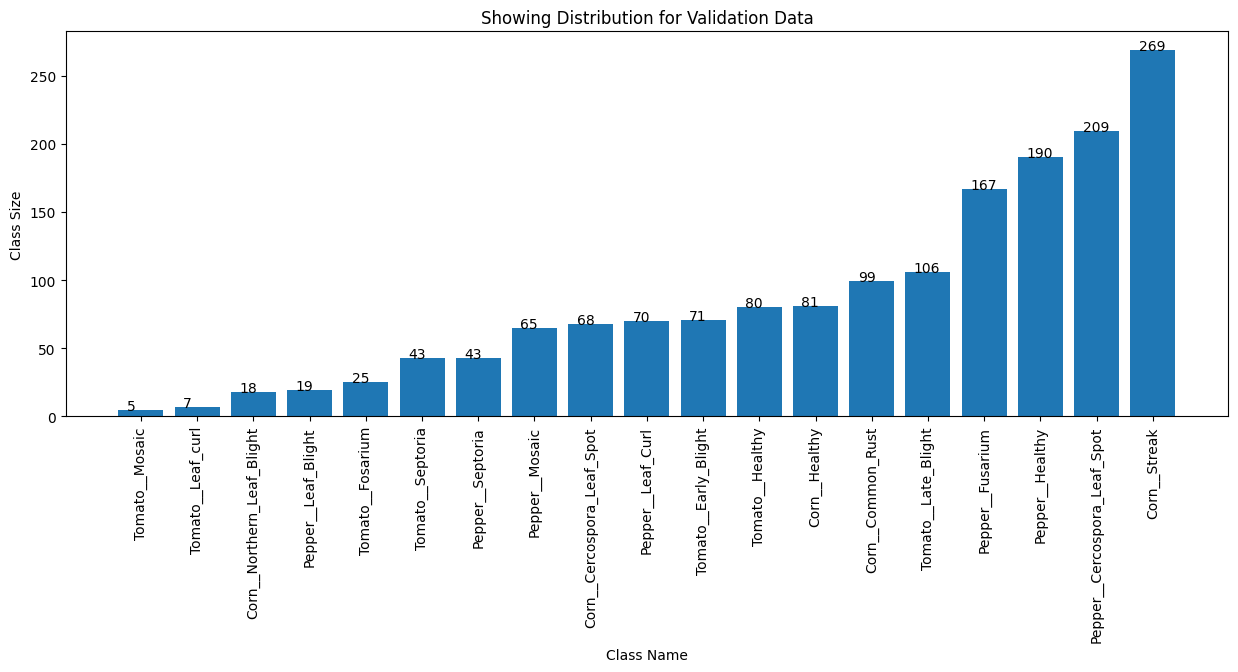

In [ ]:
plot_class_distribution("valid", sort=True)

### Preprocess Images
  Preprocessing steps include


*   Input Normalization. Pixel values should range from 0 t0 1
*   Resize Input Image to 256 * 256 or 224 * 224
* Shuffle the data




In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 64

# Import data from directories and turn it into batches
train_data = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    class_names=class_names,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

valid_data = image_dataset_from_directory(
    valid_dir,
    label_mode='categorical',
    class_names=class_names,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

test_data = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    class_names=class_names,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

# rescale input image
rescale_image_input = tf.keras.layers.Rescaling(1./255)

train_data = train_data.map(lambda x, y: (rescale_image_input(x), y))
valid_data = valid_data.map(lambda x, y: (rescale_image_input(x), y))
test_data = test_data.map(lambda x, y: (rescale_image_input(x), y))

train_data.prefetch(tf.data.AUTOTUNE)
train_data.cache()

Found 9674 files belonging to 19 classes.
Found 1635 files belonging to 19 classes.
Found 1647 files belonging to 19 classes.


<CacheDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.float32, name=None))>

## Data Visualization

> Sample Images from the Preprocessed Dataset




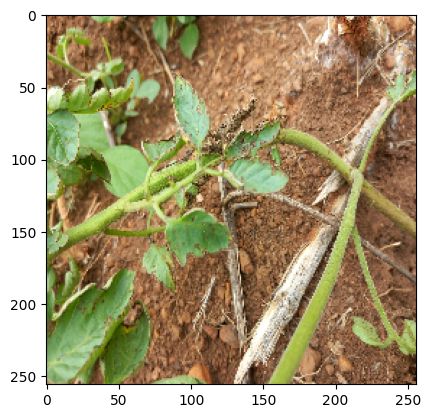

In [ ]:
random_batch_ds = next(iter(train_data))[np.random.randint(1)]
random_image = random_batch_ds[np.random.randint(0, random_batch_ds.shape[0])]
# print(random_image.numpy().astype("float64"))
plt.imshow(random_image.numpy().astype("float64"))


In [ ]:
### Displays set of Images
def view_class_specific_images_generator(class_index=0):
  g = np.where(train_labels.numpy() == class_index)[0]
  batch_g = 9
  n = int(len(g)/batch_g)
  a = (len(g) - (batch_g * n))

  for i in range(n):
    yield g[i*batch_g:(i*batch_g)+batch_g]

  if a != 0:
    yield g[(batch_g*n):-1]

In [ ]:
class_index = 2
print(f'Showing for {class_names[class_index]}')
class_indices_gen = view_class_specific_images_generator(class_index=class_index)
def view_class_specific_images(num_samples=9):
  class_indices_list = []
  plt.figure(figsize=(10, 10))
  try:
    for i, index in enumerate(next(class_indices_gen)):
      class_indices_list.append(index)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(train_images[index].numpy().astype("float64"))
      plt.title(list(class_names)[train_labels[index]])
      plt.axis("off")
    print(class_indices_list)
  except StopIteration:
    print("Generator empty")

Showing for Corn__Common_Rust


[121, 138, 155, 183, 187, 193, 197, 259, 302]


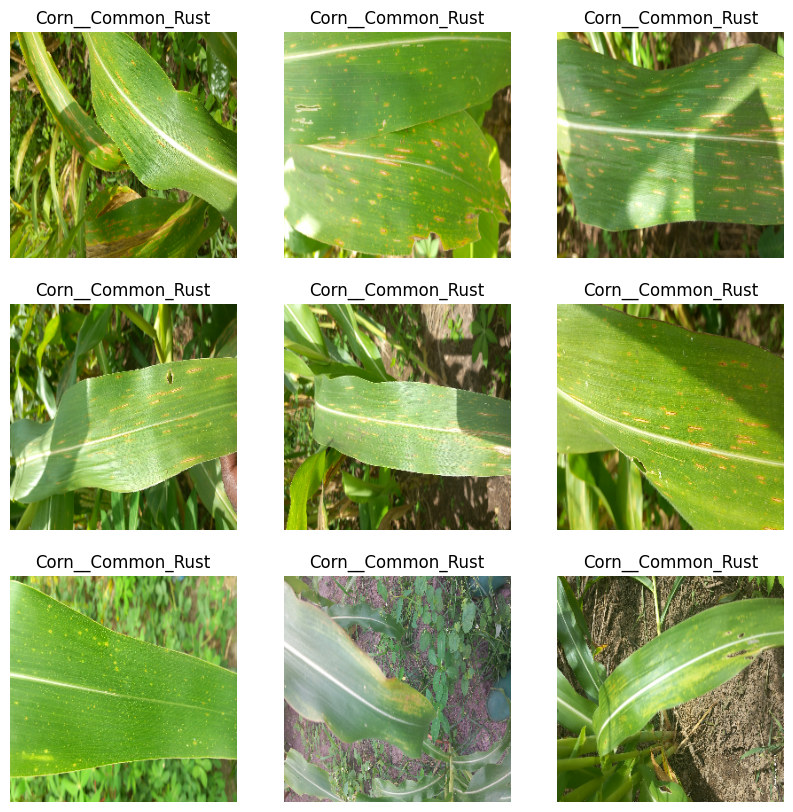

In [ ]:
view_class_specific_images()

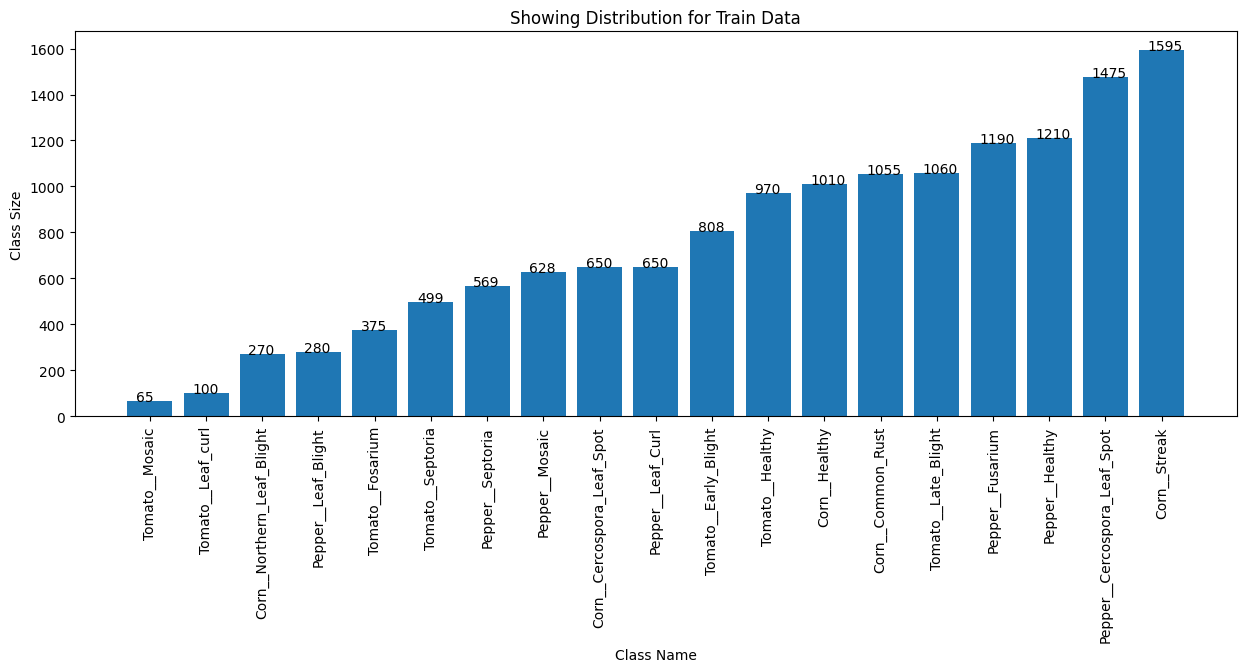

In [ ]:
plot_class_distribution(distribution="train", sort=True)

In [ ]:
def view_sample_preprocessed_images(num_samples=9):
  plt.figure(figsize=(10, 10))
  for images, labels in train_data.take(1):
    for i in range(num_samples):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("float64"))
      plt.title(np.array(class_names)[tf.argmax(labels[i])])
      plt.axis("off")

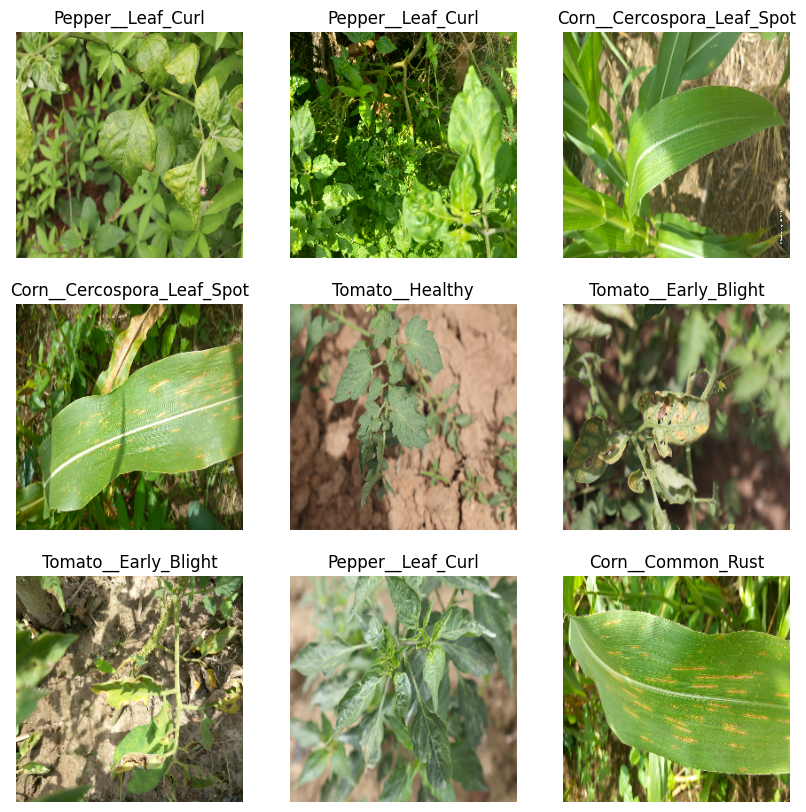

In [ ]:
view_sample_preprocessed_images(9)

## AI Model Preparation







### Compile a new model architecture



> ResNet9 Architecture.



#### ResNet9 Model Architecture

In [ ]:
# my own code replication

def conv_block(input_layer, num_filters, kernel_size=(3,3), padding="same", apply_pooling=False):
  x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding=padding)(input_layer)
  # x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  if apply_pooling:
    x = tf.keras.layers.MaxPool2D(pool_size=(4, 4))(x)

  return x

def residual_block(input_layer, num_filters, kernel_size=(3,3), padding="same", apply_pooling=False):
  y = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding=padding)(input_layer)
  # y = tf.keras.layers.BatchNormalization()(y)
  y = tf.keras.layers.ReLU()(y)

  y = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding=padding)(y)
  # y = tf.keras.layers.BatchNormalization()(y)
  y = tf.keras.layers.ReLU()(y)

  y = tf.keras.layers.add([y, input_layer])

  return y


def resnet9_model(input_layer, num_disease):

  conv_layer_1 = conv_block(input_layer, 64)
  conv_layer_2 = conv_block(conv_layer_1, 128, apply_pooling=True)
  resnet_layer_1 = residual_block(conv_layer_2, num_filters=128)

  conv_layer_3 = conv_block(resnet_layer_1, 256, apply_pooling=True)
  conv_layer_4 = conv_block(conv_layer_3, 512, apply_pooling=True)
  resnet_layer_2 = residual_block(conv_layer_4, num_filters=512)

  maxpool_layer_1 = tf.keras.layers.MaxPool2D(pool_size=(4, 4))(resnet_layer_2)
  flatten_layer = tf.keras.layers.Flatten()(maxpool_layer_1)
  classifier_output = tf.keras.layers.Dense(num_disease, activation="softmax")(flatten_layer)

  return classifier_output

input_layer = tf.keras.Input(shape=(256, 256, 3))
model_output = resnet9_model(input_layer, 19)
resnet_model = tf.keras.models.Model(inputs=input_layer, outputs=model_output)
resnet_model.summary()

In [ ]:
tf.keras.utils.plot_model(
    agridis_scan_resnet_model,
    to_file='agridis_scan_resnet_model.png',
    show_shapes=True,
    show_layer_names=True,
    show_trainable=True
)

In [ ]:
# Compile model
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
class CalculateValidationAccuracyAtMidTraining(tf.keras.callbacks.Callback):
    """Calculates the validation accuracy and loss after time EPOCH/2.

    Arguments:
        total_num_epochs: Number of epochs model is set to train for
    """

    def __init__(self, total_num_epochs=10):
        super().__init__()
        self.mid_traning = round(total_num_epochs / 2)

    def on_epoch_end(self, epoch, logs=None):
        if np.less(self.mid_traning, epoch):
          # calculate validation loss
          self.model.evaluate(valid_data)

# Define callback to save model checkpoint after each epoch
model_checkpoint_dir = "/content/drive/MyDrive/AgricDis_Project/models/model_checkpoints/resnet9_checkpoints/7ncp-{accuracy}-{epoch:04d}.ckpt"
calc_val_callback = CalculateValidationAccuracyAtMidTraining(2)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_dir,
    monitor='accuracy',
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
)

In [ ]:
EPOCHS = 2
training_history = resnet_model.fit(train_data,
                                    epochs=EPOCHS,
                                    # class_weight=dict_class_weights,
                                    callbacks=[model_checkpoint_callback])

In [ ]:
# evaluate model performance
agridis_scan_resnet_model.evaluate(valid_data)